In [82]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

# F1 data
import fastf1 as f1

In [83]:
f1.Cache.enable_cache("cache")

schedule = pd.DataFrame(f1.get_event_schedule(2025).iloc[1:])
print(schedule.columns)

schedule = schedule[['RoundNumber', 'EventName', 'EventFormat']]

schedule['SprintWeekend'] = schedule['EventFormat'].apply(lambda x: True if x.startswith('sprint') else False)

schedule.drop(columns = ['EventFormat'], inplace=True)

schedule.head()

Index(['RoundNumber', 'Country', 'Location', 'OfficialEventName', 'EventDate',
       'EventName', 'EventFormat', 'Session1', 'Session1Date',
       'Session1DateUtc', 'Session2', 'Session2Date', 'Session2DateUtc',
       'Session3', 'Session3Date', 'Session3DateUtc', 'Session4',
       'Session4Date', 'Session4DateUtc', 'Session5', 'Session5Date',
       'Session5DateUtc', 'F1ApiSupport'],
      dtype='object')


,RoundNumber,EventName,SprintWeekend
1,1,Australian Grand Prix,False
2,2,Chinese Grand Prix,True
3,3,Japanese Grand Prix,False
4,4,Bahrain Grand Prix,False
5,5,Saudi Arabian Grand Prix,False


In [84]:
"""
all_results = pd.DataFrame()
years = [2025]

for year in years:
    prev_season = f1.get_event_schedule(year)
    prev_season = prev_season[~prev_season.is_testing()]

    for index, event in prev_season.iterrows():
        if (event['EventDate'] > pd.Timestamp.today()):
            break
        name = event['EventName']

        event = f1.get_event(year, name)
        race = event.get_race()
        race.load(weather=True)
    
        results = race.results
        print(results['ClassifiedPosition'])

        results = results[['Abbreviation', 'TeamId', 'GridPosition', 'Position', 'Time', 'Status']]

        results['Race'] = event['EventName']

        results['TotalTime'] = results['Time']

        leading = 0
        for i in range(1, len(results)):
            if(results['Time'].iloc[i] < results['Time'].iloc[i-1]):
                leading = i-1
            results['TotalTime'].iloc[i] = results['TotalTime'].iloc[leading] + results['Time'].iloc[i]
            

        results["Time"] = results["TotalTime"].astype('int64').replace(-9223372036854775808, np.nan)
        #results = results.drop(columns = ['TotalTime'])

        rain = race.weather_data['Rainfall']        
        rain_score = rain.sum() / len(rain)
        results['Rain'] = rain_score

        temp = race.weather_data['TrackTemp']
        results['Temp'] = temp
        
        all_results = pd.concat([all_results, results], ignore_index=True)

all_results.to_csv("25.csv")
"""

"""results24 = pd.read_csv("22.csv", index_col=0)
results22 = pd.read_csv("23.csv", index_col=0)
results23 = pd.read_csv("24.csv", index_col=0)
results25 = pd.read_csv("25.csv", index_col=0)

all_results = pd.concat([results24, results22, results23, results25], ignore_index=True)"""

'results24 = pd.read_csv("22.csv", index_col=0)\nresults22 = pd.read_csv("23.csv", index_col=0)\nresults23 = pd.read_csv("24.csv", index_col=0)\nresults25 = pd.read_csv("25.csv", index_col=0)\n\nall_results = pd.concat([results24, results22, results23, results25], ignore_index=True)'

In [85]:
all_results = pd.read_csv("all_results.csv", index_col=0)

all_results

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain
0,LEC,ferrari,1.0,1.0,5.853584e+12,Finished,Bahrain Grand Prix,0.0
1,SAI,ferrari,3.0,2.0,5.859182e+12,Finished,Bahrain Grand Prix,0.0
2,HAM,mercedes,5.0,3.0,5.863259e+12,Finished,Bahrain Grand Prix,0.0
3,RUS,mercedes,9.0,4.0,5.864795e+12,Finished,Bahrain Grand Prix,0.0
4,MAG,haas,7.0,5.0,5.868338e+12,Finished,Bahrain Grand Prix,0.0
...,...,...,...,...,...,...,...,...
55,HUL,sauber,16.0,16.0,5.008940e+12,Finished,Japanese Grand Prix,0.0
56,LAW,rb,13.0,17.0,5.009717e+12,Finished,Japanese Grand Prix,0.0
57,OCO,haas,18.0,18.0,5.010421e+12,Finished,Japanese Grand Prix,0.0
58,BOR,sauber,17.0,19.0,5.010880e+12,Finished,Japanese Grand Prix,0.0


In [86]:
all_results['Status'].unique()
classified = ['Finished', '+1 Lap', '+2 Laps', '+6 Laps', 'Lapped']

In [87]:
all_results = pd.read_csv("all_results.csv", index_col=0)
all_results['ClassifiedPosition'] = all_results.apply(lambda row: np.nan if row['Status'] not in classified else row['Position'], axis=1)
all_results

,Driver,TeamId,GridPosition,Position,Time,Status,Race,Rain,ClassifiedPosition
0,LEC,ferrari,1.0,1.0,5.853584e+12,Finished,Bahrain Grand Prix,0.0,1.0
1,SAI,ferrari,3.0,2.0,5.859182e+12,Finished,Bahrain Grand Prix,0.0,2.0
2,HAM,mercedes,5.0,3.0,5.863259e+12,Finished,Bahrain Grand Prix,0.0,3.0
3,RUS,mercedes,9.0,4.0,5.864795e+12,Finished,Bahrain Grand Prix,0.0,4.0
4,MAG,haas,7.0,5.0,5.868338e+12,Finished,Bahrain Grand Prix,0.0,5.0
...,...,...,...,...,...,...,...,...,...
55,HUL,sauber,16.0,16.0,5.008940e+12,Finished,Japanese Grand Prix,0.0,16.0
56,LAW,rb,13.0,17.0,5.009717e+12,Finished,Japanese Grand Prix,0.0,17.0
57,OCO,haas,18.0,18.0,5.010421e+12,Finished,Japanese Grand Prix,0.0,18.0
58,BOR,sauber,17.0,19.0,5.010880e+12,Finished,Japanese Grand Prix,0.0,19.0


In [88]:
all_results = all_results.drop(columns=['Time', 'Status'])
all_results.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Position', 'Race', 'Rain',
       'ClassifiedPosition'],
      dtype='object')

In [89]:
drivers = all_results['Driver'].unique()
drivers
teams = all_results['TeamId'].unique()
teams

array(['ferrari', 'mercedes', 'haas', 'sauber', 'alpine', 'rb',
       'aston_martin', 'williams', 'mclaren', 'red_bull'], dtype=object)

In [90]:
current_drivers = ['NOR', 'PIA', 'LEC', 'HAM', 'VER', 'TSU', 'OCO', 'BEA', 'LAW', 'HAD', 'ANT', 'RUS', 'GAS', 'DOO', 'ALO', 'STR', 'HUL', 'BOR', 'SAI', 'ALB']

### Adding hand written test inputs

In [91]:
race = 'Bahrain Grand Prix'
round = 4

In [92]:
test = pd.DataFrame([["NOR", "mclaren", 6], ["PIA", "mclaren", 1],
                     ["LEC", "ferrari", 3], ["HAM", "ferrari", 9],
                     ["VER", "red_bull", 7], ["TSU", "red_bull", 10],
                     ["OCO", "haas", 14], ["BEA", "haas", 20],
                     ["LAW", "rb", 17], ["HAD", "rb", 12],
                     ["ANT", "mercedes", 4], ["RUS", "mercedes", 2],
                     ["GAS", "alpine", 5], ["DOO", "alpine", 11],
                     ["ALO", "aston_martin", 13], ["STR", "aston_martin", 19],
                     ["HUL", "sauber", 16], ["BOR", "sauber", 18],
                     ["SAI", "williams", 8], ["ALB", "williams", 15]])

test.columns = ['Driver', 'TeamId', 'GridPosition']
test['Race'] = race
test['Rain'] = 'None'

In [93]:
all_results = pd.concat([all_results, test], ignore_index=True)

test.drop(test.index, inplace=True)

all_results.tail()

,Driver,TeamId,GridPosition,Position,Race,Rain,ClassifiedPosition
1474,STR,aston_martin,19.0,NaN,Bahrain Grand Prix,None,NaN
1475,HUL,sauber,16.0,NaN,Bahrain Grand Prix,None,NaN
1476,BOR,sauber,18.0,NaN,Bahrain Grand Prix,None,NaN
1477,SAI,williams,8.0,NaN,Bahrain Grand Prix,None,NaN
1478,ALB,williams,15.0,NaN,Bahrain Grand Prix,None,NaN


### Calculating lagged performcane metrics

In [94]:
driver_lagged = pd.DataFrame()

ls = []
for driver in drivers:
    dr = all_results[all_results['Driver'] == driver]
    dr['ClassifiedPosition'] = dr['ClassifiedPosition'].ffill()
    dr['DriverLast1'] = dr['ClassifiedPosition'].shift(1)
    dr['DriverLast3'] = dr['DriverLast1'].rolling(window=3, min_periods=1).mean()
    dr['DriverLast5'] = dr['DriverLast1'].rolling(window=5, min_periods=1).mean()
    dr['DriverLast10'] = dr['DriverLast1'].rolling(window=10, min_periods=1).mean()

    if driver in current_drivers:
        ls.append(dr[:-1])
        test = pd.concat([test, pd.DataFrame(dr[-1:])], ignore_index=True)
    else:
        ls.append(dr)

driver_lagged = pd.concat(ls, ignore_index=False)
driver_lagged = driver_lagged.sort_index()

C:\Users\abdul\AppData\Local\Temp\ipykernel_27204\2739688924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['ClassifiedPosition'] = dr['ClassifiedPosition'].ffill()
C:\Users\abdul\AppData\Local\Temp\ipykernel_27204\2739688924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr['DriverLast1'] = dr['ClassifiedPosition'].shift(1)
C:\Users\abdul\AppData\Local\Temp\ipykernel_27204\2739688924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [95]:
driver_lagged = pd.concat([driver_lagged, test], ignore_index=True)
test.drop(test.index, inplace=True)

In [96]:
dataset = driver_lagged.sort_index()

### Adding lagged performance metrics

In [97]:
ls = []
for team in teams:
    tm = dataset[dataset['TeamId'] == team]
    tm['Group'] = np.floor(np.arange(len(tm)) / 2)
    tm['TeamLast1'] = tm.groupby('Group')['DriverLast1'].transform('mean')
    tm['TeamLast3'] = tm.groupby('Group')['TeamLast1'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    tm['TeamLast5'] = tm.groupby('Group')['TeamLast1'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    tm['TeamLast10'] = tm.groupby('Group')['TeamLast1'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    ls.append(tm[:-2])

    test = pd.concat([test, pd.DataFrame(tm[-2:])], ignore_index=True)
    
dataset = pd.concat(ls, ignore_index=False)


C:\Users\abdul\AppData\Local\Temp\ipykernel_27204\1567619428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tm['Group'] = np.floor(np.arange(len(tm)) / 2)
C:\Users\abdul\AppData\Local\Temp\ipykernel_27204\1567619428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tm['TeamLast1'] = tm.groupby('Group')['DriverLast1'].transform('mean')
C:\Users\abdul\AppData\Local\Temp\ipykernel_27204\1567619428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [98]:
bins = [-0.001, 0, 0.1, 0.5, dataset['Rain'].max() + 0.001]
labels = ['None', 'Light', 'Moderate', 'Heavy']

dataset['Rain'] = pd.cut(dataset['Rain'], bins=bins, labels=labels)

In [99]:
dataset.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Position', 'Race', 'Rain',
       'ClassifiedPosition', 'DriverLast1', 'DriverLast3', 'DriverLast5',
       'DriverLast10', 'Group', 'TeamLast1', 'TeamLast3', 'TeamLast5',
       'TeamLast10'],
      dtype='object')

In [100]:
dataset = dataset.drop(columns=['ClassifiedPosition', 'Group'])
dataset.sort_index()
test = test[dataset.columns]
dataset = dataset.sort_index()

In [101]:
# Define features
categorical_features = ['Driver', 'TeamId', 'Race', 'Rain']
numerical_features = [col for col in dataset.columns 
                      if col not in categorical_features + ['Position', 'ClassifiedPosition']]

# Drop rows with missing target
dataset = dataset.dropna()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='error'), categorical_features)
])

# Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


## Fitting the model with the dataset

In [102]:
# Features and target
X = dataset[categorical_features + numerical_features]
print(X.columns)
y = dataset['Position']

model_pipeline.fit(X, y)

# Define K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(model_pipeline, X, y, cv=kfold, scoring='neg_root_mean_squared_error')

print(mae_scores.mean())

Index(['Driver', 'TeamId', 'Race', 'Rain', 'GridPosition', 'DriverLast1',
       'DriverLast3', 'DriverLast5', 'DriverLast10', 'TeamLast1', 'TeamLast3',
       'TeamLast5', 'TeamLast10'],
      dtype='object')
-4.355541379912918


In [103]:
test = test.drop(columns=['Position'])

In [104]:
X = test[categorical_features + numerical_features]
pred = pd.DataFrame(model_pipeline.predict(X))
print(pred.var())

0    16.403963
dtype: float64


In [105]:
pred.columns = ["Position"]

prediction = pd.concat([test, pred], axis=1)

prediction = prediction.sort_values(by='Position', ascending=True)

prediction


,Driver,TeamId,GridPosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
17,PIA,mclaren,1.0,Bahrain Grand Prix,None,3.0,4.333333,4.60,5.900,2.5,2.5,2.5,2.5,4.43
19,VER,red_bull,7.0,Bahrain Grand Prix,None,1.0,2.333333,2.60,3.200,6.5,6.5,6.5,6.5,4.94
2,RUS,mercedes,2.0,Bahrain Grand Prix,None,5.0,3.666667,3.40,3.600,5.5,5.5,5.5,5.5,5.26
3,ANT,mercedes,4.0,Bahrain Grand Prix,None,6.0,5.333333,5.20,5.200,5.5,5.5,5.5,5.5,5.60
16,NOR,mclaren,6.0,Bahrain Grand Prix,None,2.0,1.666667,1.60,3.300,2.5,2.5,2.5,2.5,6.06
0,LEC,ferrari,3.0,Bahrain Grand Prix,None,4.0,6.666667,7.20,5.300,5.5,5.5,5.5,5.5,7.31
8,GAS,alpine,5.0,Bahrain Grand Prix,None,13.0,11.666667,11.40,8.500,14.0,14.0,14.0,14.0,9.66
1,HAM,ferrari,9.0,Bahrain Grand Prix,None,7.0,9.000000,9.40,7.900,5.5,5.5,5.5,5.5,9.74
14,SAI,williams,8.0,Bahrain Grand Prix,None,14.0,11.333333,9.20,5.900,12.0,12.0,12.0,12.0,10.14
15,ALB,williams,15.0,Bahrain Grand Prix,None,9.0,7.000000,6.60,10.700,9.0,9.0,9.0,9.0,11.01


In [106]:
australia = dataset[(1-round)*20 : (2-round)*20].reset_index(drop=True)
china = dataset[(2-round)*20 : (3-round)*20].reset_index(drop=True)
japan = dataset[(3-round)*20 :].reset_index(drop=True)

previous = [australia, china, japan]

In [107]:
predictions = []

for race in previous:
    test = race
    
    test.rename(columns={'Position': 'TruePosition'}, inplace=True)

    X = test[categorical_features + numerical_features]

    pred = pd.DataFrame(model_pipeline.predict(X))
    print(pred.var())

    pred.columns = ["Position"]

    pred = pd.concat([test, pred], axis=1)

    pred = pred.sort_values(by='Position', ascending=True) 
    predictions.append(pred)

    mae = mean_absolute_error(pred['TruePosition'], pred['Position'])
    print(mae)


0    22.780382
dtype: float64
1.2274999999999996
0    23.584225
dtype: float64
1.184
0    28.719863
dtype: float64
0.731


In [108]:
predictions[0]

,Driver,TeamId,GridPosition,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
1,VER,red_bull,3.0,2.0,Australian Grand Prix,Moderate,4.0,4.000000,3.600000,3.500000,8.0,8.0,8.0,8.0,2.45
0,NOR,mclaren,1.0,1.0,Australian Grand Prix,Moderate,2.0,1.333333,4.000000,3.700000,1.5,1.5,1.5,1.5,3.06
2,RUS,mercedes,4.0,3.0,Australian Grand Prix,Moderate,3.0,3.666667,3.200000,3.800000,4.5,4.5,4.5,4.5,3.20
3,ANT,mercedes,16.0,4.0,Australian Grand Prix,Moderate,6.0,5.000000,5.000000,5.000000,4.5,4.5,4.5,4.5,6.97
8,PIA,mclaren,2.0,9.0,Australian Grand Prix,Moderate,1.0,6.666667,6.000000,5.500000,1.5,1.5,1.5,1.5,7.50
4,ALB,williams,6.0,5.0,Australian Grand Prix,Moderate,7.0,7.666667,10.800000,11.600000,4.5,4.5,4.5,4.5,7.71
5,STR,aston_martin,13.0,6.0,Australian Grand Prix,Moderate,9.0,9.666667,11.800000,12.900000,9.0,9.0,9.0,9.0,8.15
7,LEC,ferrari,7.0,8.0,Australian Grand Prix,Moderate,8.0,6.333333,5.000000,4.100000,9.0,9.0,9.0,9.0,8.28
6,HUL,sauber,17.0,7.0,Australian Grand Prix,Moderate,15.0,10.000000,9.200000,9.200000,14.5,14.5,14.5,14.5,9.66
9,HAM,ferrari,8.0,10.0,Australian Grand Prix,Moderate,10.0,8.000000,7.600000,7.300000,9.0,9.0,9.0,9.0,9.76


In [109]:
predictions[1]

,Driver,TeamId,GridPosition,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
0,PIA,mclaren,1.0,1.0,Chinese Grand Prix,None,9.0,6.333333,6.400000,6.300000,5.0,5.0,5.0,5.0,2.05
1,NOR,mclaren,3.0,2.0,Chinese Grand Prix,None,1.0,1.333333,3.000000,3.400000,5.0,5.0,5.0,5.0,2.89
2,RUS,mercedes,2.0,3.0,Chinese Grand Prix,None,3.0,3.000000,3.600000,3.800000,3.5,3.5,3.5,3.5,3.26
3,VER,red_bull,4.0,4.0,Chinese Grand Prix,None,2.0,2.666667,3.000000,3.200000,7.0,7.0,7.0,7.0,4.02
5,ANT,mercedes,8.0,6.0,Chinese Grand Prix,None,4.0,4.666667,4.666667,4.666667,3.5,3.5,3.5,3.5,6.00
4,OCO,haas,11.0,5.0,Chinese Grand Prix,None,13.0,10.333333,13.000000,12.600000,13.5,13.5,13.5,13.5,7.44
6,ALB,williams,10.0,7.0,Chinese Grand Prix,None,5.0,5.666667,8.600000,11.400000,7.5,7.5,7.5,7.5,8.41
7,BEA,haas,17.0,8.0,Chinese Grand Prix,None,14.0,12.000000,11.600000,10.833333,13.5,13.5,13.5,13.5,8.92
8,STR,aston_martin,14.0,9.0,Chinese Grand Prix,None,6.0,7.000000,10.000000,11.600000,7.5,7.5,7.5,7.5,10.34
10,HAD,rb,7.0,11.0,Chinese Grand Prix,None,11.0,11.000000,11.000000,11.000000,11.5,11.5,11.5,11.5,10.98


In [110]:
predictions[2]

,Driver,TeamId,GridPosition,TruePosition,Race,Rain,DriverLast1,DriverLast3,DriverLast5,DriverLast10,TeamLast1,TeamLast3,TeamLast5,TeamLast10,Position
0,VER,red_bull,1.0,1.0,Japanese Grand Prix,None,4.0,3.333333,3.6,3.400000,10.0,10.0,10.0,10.0,1.34
1,NOR,mclaren,2.0,2.0,Japanese Grand Prix,None,2.0,1.666667,1.4,3.500000,1.5,1.5,1.5,1.5,2.59
2,PIA,mclaren,3.0,3.0,Japanese Grand Prix,None,1.0,3.666667,6.0,6.100000,1.5,1.5,1.5,1.5,3.47
3,LEC,ferrari,4.0,4.0,Japanese Grand Prix,None,8.0,8.000000,7.0,5.000000,9.0,9.0,9.0,9.0,4.74
4,RUS,mercedes,5.0,5.0,Japanese Grand Prix,None,3.0,3.000000,3.4,3.700000,4.5,4.5,4.5,4.5,5.15
5,ANT,mercedes,6.0,6.0,Japanese Grand Prix,None,6.0,5.333333,5.0,5.000000,4.5,4.5,4.5,4.5,5.87
6,HAM,ferrari,8.0,7.0,Japanese Grand Prix,None,10.0,10.000000,8.8,7.800000,9.0,9.0,9.0,9.0,8.09
7,HAD,rb,7.0,8.0,Japanese Grand Prix,None,11.0,11.000000,11.0,11.000000,11.5,11.5,11.5,11.5,9.10
8,ALB,williams,9.0,9.0,Japanese Grand Prix,None,7.0,6.333333,7.0,11.400000,8.5,8.5,8.5,8.5,9.47
9,BEA,haas,10.0,10.0,Japanese Grand Prix,None,8.0,10.000000,11.2,10.428571,6.5,6.5,6.5,6.5,10.28


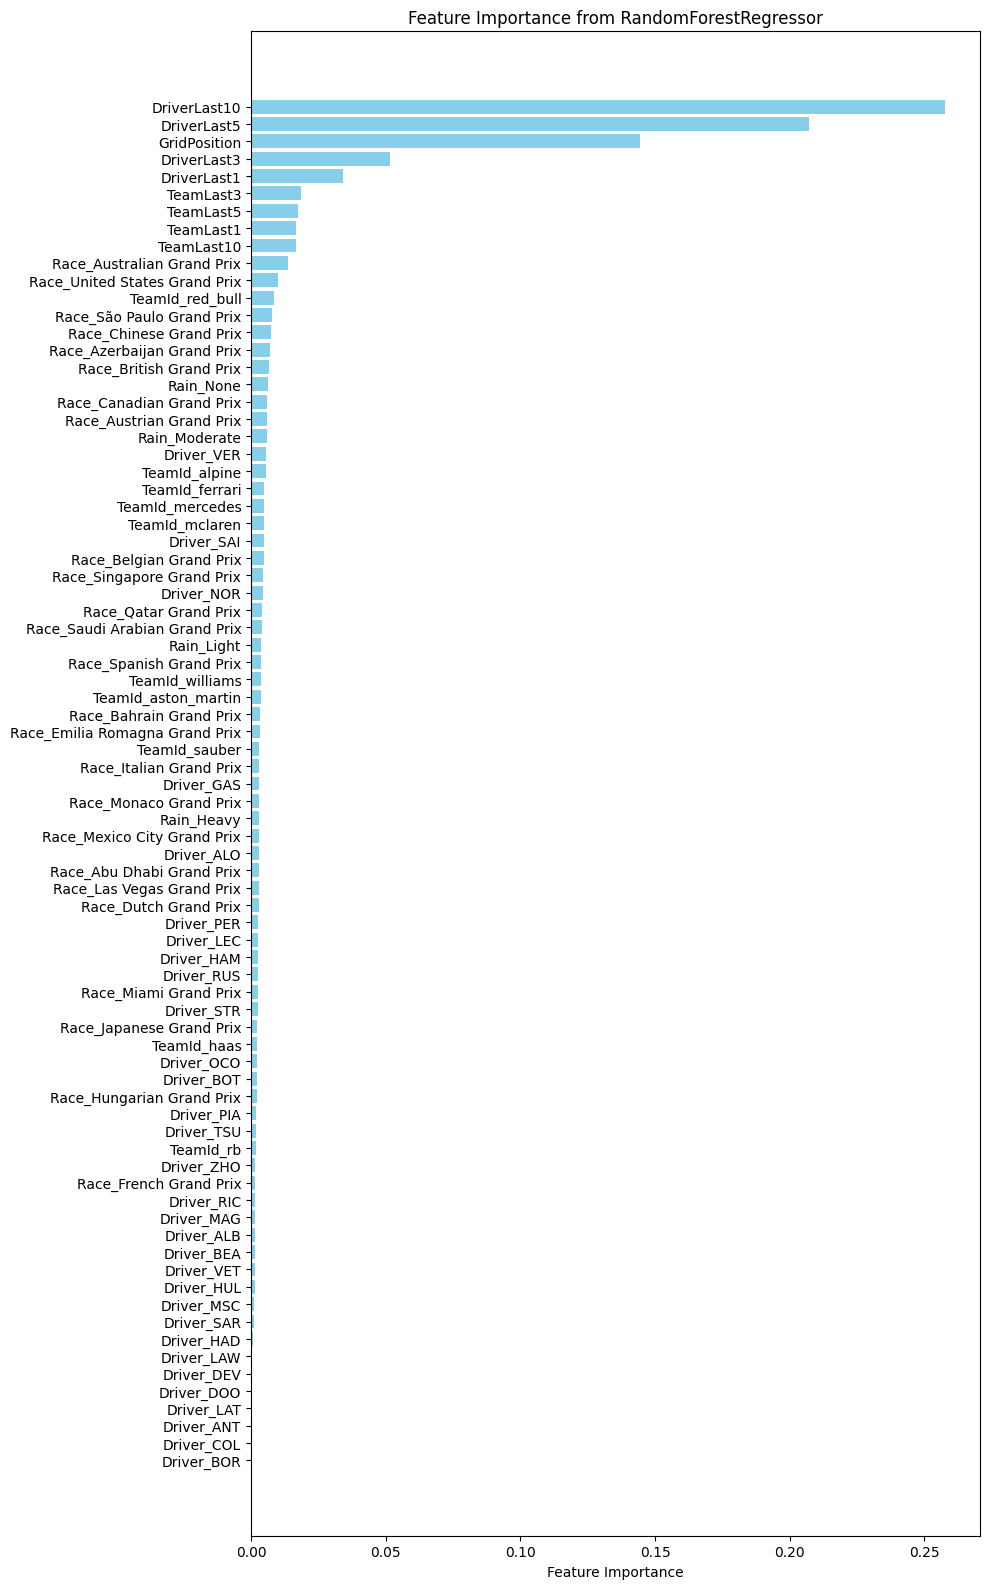

In [111]:
# Get the transformer for categorical features from your preprocessor
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Get one-hot encoded feature names (e.g., "Driver_VER", etc.)
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# The final feature names are (typically) the numerical features first,
# followed by the transformed categorical features.
final_feature_names = list(numerical_features) + list(cat_feature_names)

# --- Step 2: Retrieve Feature Importances from the RandomForestRegressor ---
# Access the regressor within the pipeline
rf_model = model_pipeline.named_steps['regressor']

# Get the feature importances array
importances = rf_model.feature_importances_

# Create a DataFrame for convenience and sort by importance
importance_df = pd.DataFrame({
    'feature': final_feature_names,
    'importance': importances
})
importance_df.sort_values(by='importance', ascending=True, inplace=True)

# --- Step 3: Plot the Feature Importance Chart ---
plt.figure(figsize=(10, 16))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance from RandomForestRegressor")
plt.tight_layout()
plt.show()